<a href="https://colab.research.google.com/github/amoghgadagi/Kaggle_Notebooks/blob/main/CNN%2BPyTorch%2BCIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip3 install torch torchvision

In [27]:
from torchvision import datasets, transforms, models
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
from torchvision.transforms.transforms import Normalize
IMAGE_SIZE = (32, 32)
BATCH_SIZE = 32
transform_train = transforms.Compose([transforms.Resize((32,32)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
                                      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])
                      
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Resize(IMAGE_SIZE),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

training_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
validation_dataset= datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_data = torch.utils.data.DataLoader(dataset = training_dataset, batch_size= BATCH_SIZE, shuffle =True)
validation_data = torch.utils.data.DataLoader(dataset = validation_dataset, batch_size= BATCH_SIZE, shuffle =True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainSteps = len(train_data.dataset)
valSteps = len(validation_data.dataset)

In [6]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image * np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
  image = image.clip(0, 1)
  return image

In [7]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = 10

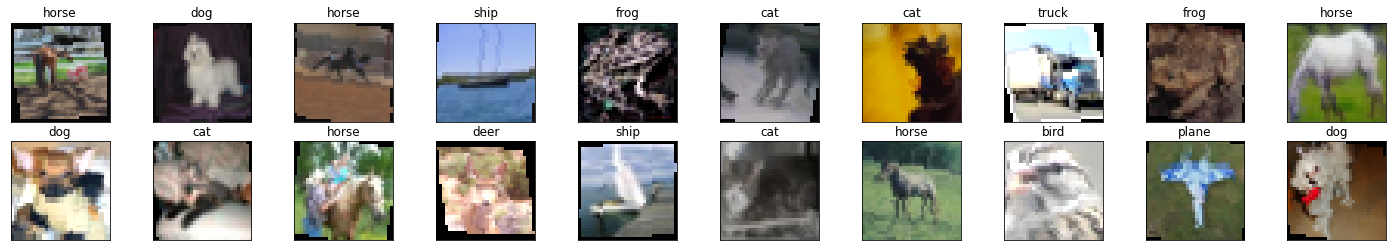

In [8]:
dataiter = iter(train_data)
images, labels = dataiter.next()
images_study = images
fig = plt.figure(figsize = (25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])

In [9]:
images_study[1].shape

torch.Size([3, 32, 32])

In [10]:
# class LeNet(nn.Module):
#   def __init__(self):
#     super().__init__()
#     self.conv1 = nn.Conv2d(3, 64, 3, 1, padding=1)
#     self.conv2 = nn.Conv2d(64, 128, 3, 1, padding=1)
#     self.conv3 = nn.Conv2d(128, 64, 3, 1)
#     self.fc1 = nn.Linear(3*3*64, 500)
#     self.dropout1 = nn.Dropout(0.5)
#     self.fc2 = nn.Linear(500, num_classes)

#   def forward(self, x):
#     x = F.relu(self.conv1(x))
#     x = F.max_pool2d(x, 2, 2)
#     x = F.relu(self.conv2(x))
#     x = F.max_pool2d(x, 2, 2)
#     x = F.relu(self.conv3(x))
#     x = F.max_pool2d(x, 2, 2)
#     x = x.view(-1, 3*3*64)
#     x = F.relu(self.fc1(x))
#     x = self.dropout1(x)
#     x = self.fc2(x)
#     return x

class LeNet(nn.Module):
    def __init__(self):
      super().__init__()
      self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
      self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
      self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
      self.fc1 = nn.Linear(4*4*64, 500)
      self.dropout1 = nn.Dropout(0.5)
      self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
      x = F.relu(self.conv1(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv2(x))
      x = F.max_pool2d(x, 2, 2)
      x = F.relu(self.conv3(x))
      x = F.max_pool2d(x, 2, 2)
      x = x.view(-1, 4*4*64)
      x = F.relu(self.fc1(x))
      x = self.dropout1(x)
      x = self.fc2(x)
      return x

In [11]:
model = LeNet().to(device)

In [12]:
model

LeNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

In [14]:
epochs = 15
running_loss_history = []
running_accuracy_history = []
validation_running_loss_history = []
validation_running_accuracy_history = []

for e in range(epochs):
  running_loss=0.
  running_accuracy = 0.
  validation_running_loss = 0.
  validation_running_accuracy = 0.
  for inputs, labels in train_data:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss +=loss.item()
    running_accuracy +=torch.sum(preds == labels.data)

  else:

    with torch.no_grad():
      for val_inputs, val_labels in validation_data:
        val_inputs = val_inputs.to(device)
        val_labels = val_labels.to(device)
        val_outputs = model(val_inputs)
        val_loss = criterion(val_outputs, val_labels)

        _, val_preds = torch.max(val_outputs, 1)
        validation_running_loss +=val_loss.item()
        validation_running_accuracy += torch.sum(val_preds == val_labels.data)

    epoch_loss = running_loss/trainSteps *100
    epoch_accuracy = running_accuracy.float()/trainSteps*100
    running_loss_history.append(epoch_loss)
    running_accuracy_history.append(epoch_accuracy.cpu().detach().numpy())

    val_epoch_loss = validation_running_loss/valSteps *100
    val_epoch_accuracy = validation_running_accuracy/valSteps *100
    validation_running_loss_history.append(val_epoch_loss)
    validation_running_accuracy_history.append(val_epoch_accuracy.cpu().detach().numpy())

    print('epoch :', (e+1))
    print('training loss: {:.4f}, accuracy: {:.4f} '.format(epoch_loss, epoch_accuracy.item()))
    print('validation loss: {:.4f}, validation accuracy: {:.4f} '.format(val_epoch_loss, val_epoch_accuracy.item()))





epoch : 1
training loss: 4.9938, accuracy: 41.2760 
validation loss: 4.1015, validation accuracy: 52.6900 
epoch : 2
training loss: 4.0729, accuracy: 52.9520 
validation loss: 3.5634, validation accuracy: 59.8600 
epoch : 3
training loss: 3.7021, accuracy: 57.8500 
validation loss: 3.1975, validation accuracy: 64.0800 
epoch : 4
training loss: 3.4389, accuracy: 60.9460 
validation loss: 3.1086, validation accuracy: 65.4800 
epoch : 5
training loss: 3.2761, accuracy: 63.2800 
validation loss: 2.9498, validation accuracy: 67.0500 
epoch : 6
training loss: 3.1554, accuracy: 64.5100 
validation loss: 2.7704, validation accuracy: 69.3600 
epoch : 7
training loss: 3.0610, accuracy: 65.8640 
validation loss: 2.7217, validation accuracy: 69.6700 
epoch : 8
training loss: 2.9859, accuracy: 66.6560 
validation loss: 2.7728, validation accuracy: 69.5000 
epoch : 9
training loss: 2.9067, accuracy: 67.5640 
validation loss: 2.6651, validation accuracy: 70.3600 
epoch : 10
training loss: 2.8632, acc

No handles with labels found to put in legend.


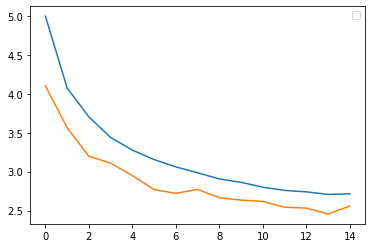

In [15]:
plt.plot(running_loss_history)
plt.plot(validation_running_loss_history)
plt.legend()

No handles with labels found to put in legend.


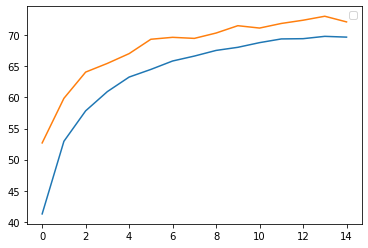

In [16]:
plt.plot(running_accuracy_history)
plt.plot(validation_running_accuracy_history)
plt.legend()

In [17]:
# !pip3 install pillow==4.0.0

In [18]:
import PIL.ImageOps

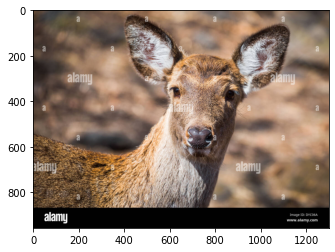

In [19]:
import requests
from PIL import Image

url = 'https://c8.alamy.com/comp/DYC06A/hornless-reindeer-at-zoo-DYC06A.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

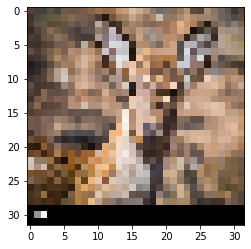

In [20]:
img = transform(img) 
plt.imshow(im_convert(img))

In [21]:
image = img.to(device).unsqueeze(0)
output = model(image)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

deer


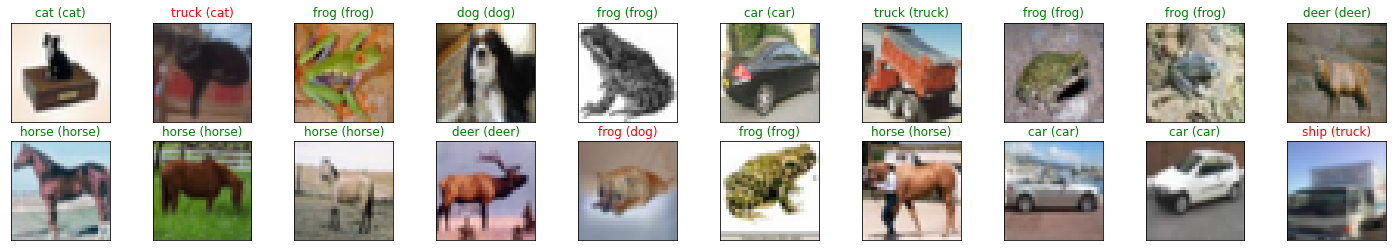

In [26]:
dataiter = iter(validation_data)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title("{} ({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color=("green" if preds[idx]==labels[idx] else "red"))
